![img](ep8_2018-57x57.png)

# To bar, or not to bar - what is the intention?
## part II

**post @** [endlesspint.com](http://endlesspint.com/2018-11-07-to-bar-or-not-to-bar/)

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_param_stats = pd.read_excel("param_stats.xlsx")
print(df_param_stats.dtypes)
print(df_param_stats.shape)
df_param_stats.head()

d_threshold       int64
m_nights          int64
change_rate     float64
binary_eval        bool
incl_contra        bool
setting_run       int64
median_tally    float64
mean_tally      float64
mean_cuml       float64
dtype: object
(10800, 9)


,d_threshold,m_nights,change_rate,binary_eval,incl_contra,setting_run,median_tally,mean_tally,mean_cuml
0,-3,10,0.9,True,True,0,121.0,161.75,154.94
1,-3,10,0.9,True,True,1,269.0,282.62,282.08
2,-3,10,0.9,True,True,2,165.0,242.26,231.28
3,-3,10,0.9,True,True,3,152.0,253.59,252.72
4,-3,10,0.9,True,True,4,274.0,328.09,328.00


In [3]:
import seaborn as sns

sns.__version__

# dot plot with ci lines for settings
    # or: https://seaborn.pydata.org/generated/seaborn.violinplot.html

# also, CLT: run above N times and grab mean

'0.9.0'

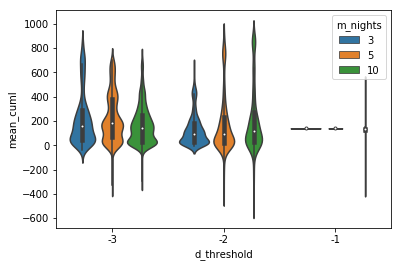

In [4]:
ax = sns.violinplot(x="d_threshold", y="mean_cuml", hue="m_nights", data=df_param_stats)

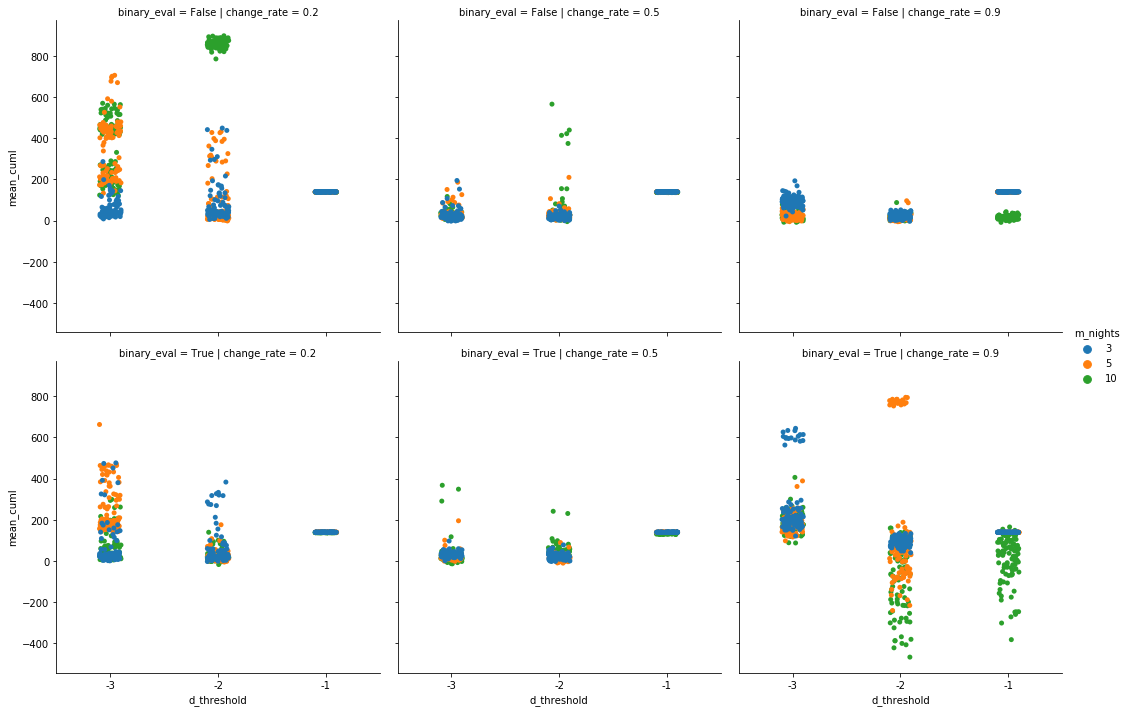

In [5]:
ax = sns.catplot(x="d_threshold", y="mean_cuml", hue="m_nights", row="binary_eval", col="change_rate", 
                 data=df_param_stats[df_param_stats.incl_contra==False])
# plt.axhline(y=192, linewidth=5, color='red')

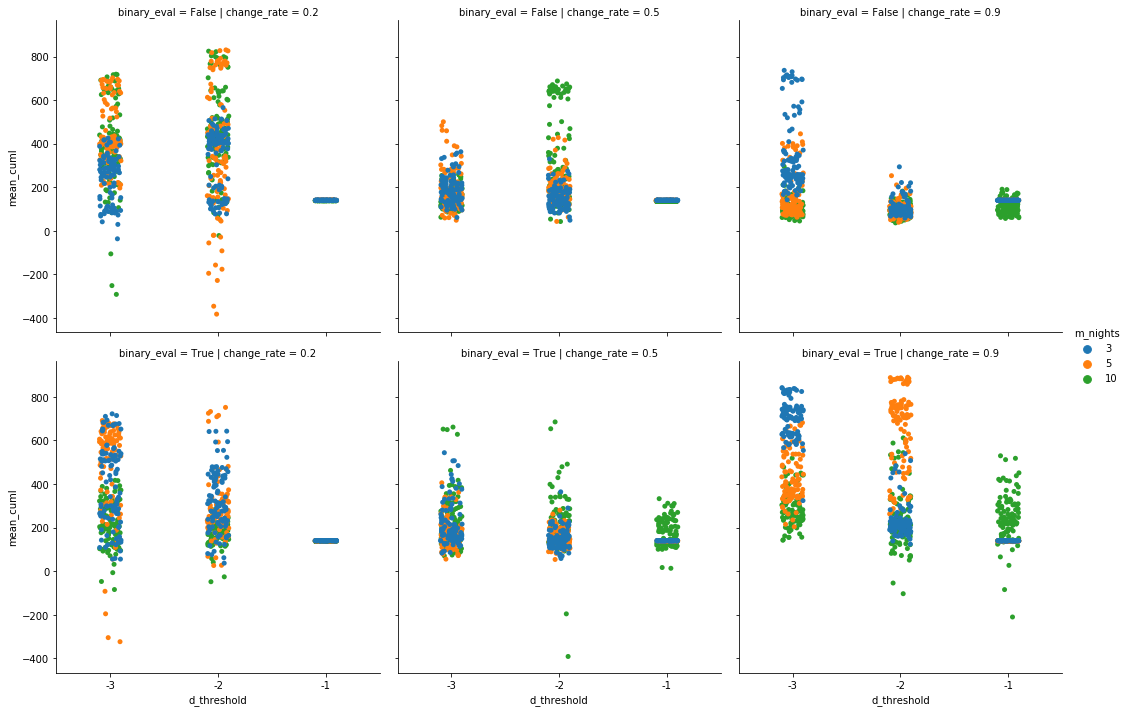

In [6]:
ax = sns.catplot(x="d_threshold", y="mean_cuml", hue="m_nights", row="binary_eval", col="change_rate", data=df_param_stats[df_param_stats.incl_contra==True])

In [7]:
# use decision tree to identify parameters/thresholds to get high score (25+)
    # i.e., change_rate == 0.2, m_nights == 10, etc.

In [8]:
import statsmodels.api as sm
# code template: http://blog.yhat.com/posts/logistic-regression-and-python.html

In [9]:
print(df_param_stats.mean_cuml.describe())
df_param_stats.head()

count    10800.000000
mean       172.231587
std        174.629543
min       -466.440000
25%         65.175000
50%        139.620000
75%        192.010000
max        897.500000
Name: mean_cuml, dtype: float64


,d_threshold,m_nights,change_rate,binary_eval,incl_contra,setting_run,median_tally,mean_tally,mean_cuml
0,-3,10,0.9,True,True,0,121.0,161.75,154.94
1,-3,10,0.9,True,True,1,269.0,282.62,282.08
2,-3,10,0.9,True,True,2,165.0,242.26,231.28
3,-3,10,0.9,True,True,3,152.0,253.59,252.72
4,-3,10,0.9,True,True,4,274.0,328.09,328.00


In [10]:
df_param_stats.columns

Index(['d_threshold', 'm_nights', 'change_rate', 'binary_eval', 'incl_contra',
       'setting_run', 'median_tally', 'mean_tally', 'mean_cuml'],
      dtype='object')

In [11]:
dummy_binary = pd.get_dummies(df_param_stats.binary_eval, prefix="binary")
dummy_binary.head()

,binary_False,binary_True
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [12]:
dummy_contrary = pd.get_dummies(df_param_stats.incl_contra, prefix="contrarians")
dummy_contrary.head()

,contrarians_False,contrarians_True
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [13]:
dummy_top_q = pd.get_dummies(df_param_stats.mean_cuml>192., prefix="top_q")
dummy_top_q.head()

,top_q_False,top_q_True
0,1,0
1,0,1
2,0,1
3,0,1
4,0,1


In [14]:
cols_to_keep = ['d_threshold', 'm_nights', 'change_rate']
df_param_classify = df_param_stats[cols_to_keep].join(dummy_binary.binary_True).join(dummy_contrary.contrarians_True).join(dummy_top_q.top_q_True)
df_param_classify.head()

,d_threshold,m_nights,change_rate,binary_True,contrarians_True,top_q_True
0,-3,10,0.9,1,1,0
1,-3,10,0.9,1,1,1
2,-3,10,0.9,1,1,1
3,-3,10,0.9,1,1,1
4,-3,10,0.9,1,1,1


In [15]:
df_param_classify['intercept'] = 1.0
df_param_classify.columns

Index(['d_threshold', 'm_nights', 'change_rate', 'binary_True',
       'contrarians_True', 'top_q_True', 'intercept'],
      dtype='object')

In [16]:
df_param_classify = df_param_classify[['top_q_True', 'd_threshold', 'm_nights', 'change_rate', 'binary_True', 'contrarians_True', 'intercept']]
df_param_classify.head()

,top_q_True,d_threshold,m_nights,change_rate,binary_True,contrarians_True,intercept
0,0,-3,10,0.9,1,1,1.0
1,1,-3,10,0.9,1,1,1.0
2,1,-3,10,0.9,1,1,1.0
3,1,-3,10,0.9,1,1,1.0
4,1,-3,10,0.9,1,1,1.0


In [17]:
train_cols = df_param_classify.columns[1:]

logit = sm.Logit(df_param_classify['top_q_True'], df_param_classify[train_cols])

# fit the model
result = logit.fit()

Optimization terminated successfully.
         Current function value: inf
         Iterations 7


C:\Users\rstancut\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\rstancut\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


In [18]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:             top_q_True   No. Observations:                10800
Model:                          Logit   Df Residuals:                    10794
Method:                           MLE   Df Model:                            5
Date:                Sun, 04 Nov 2018   Pseudo R-squ.:                     inf
Time:                        13:29:50   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
                                        LLR p-value:                     1.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
d_threshold         -1.4107      0.038    -36.904      0.000      -1.486      -1.336
m_nights             0.0545      0.009      6.052      0.000       0.037       0.072
change_rate         -1.1693 

C:\Users\rstancut\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\rstancut\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\rstancut\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\rstancut\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [19]:
# odds ratios only
print(np.exp(result.params))

# increases your shot of a good time: 
    # the more nights taken into consideration
    # updating preferences as binary decision: go / don't go
    # BIG ONE: having contrarians in the population
    
# decreases shot at good times:
    # making threshold too tight/close to zero
    # changing preferences too aggresively

d_threshold         0.243968
m_nights            1.056064
change_rate         0.310587
binary_True         1.747296
contrarians_True    9.084150
intercept           0.003861
dtype: float64


In [20]:
from sklearn import tree
# code template: http://scikit-learn.org/stable/modules/tree.html

In [21]:
# df_param_classify.columns[1:-1]
X = np.matrix(df_param_classify[['d_threshold', 'm_nights', 'change_rate', 'binary_True',
                                 'contrarians_True']])
y = np.array(df_param_classify.top_q_True)

In [22]:
X[0]

matrix([[-3. , 10. ,  0.9,  1. ,  1. ]])

In [23]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)

In [24]:
clf.predict([[-3. , 10. ,  0.9,  1. ,  1. ]])

array([1], dtype=uint8)

In [25]:
clf.predict_proba([[-3. , 10. ,  0.9,  1. ,  1. ]])

array([[0.09, 0.91]])

In [26]:
clf.predict_proba([[-3. , 10. ,  0.9,  1. ,  1. ]])[0][1]

0.91

In [27]:
ds = [-3, -2, -1]
ms = [10., 5., 3.]
cr = [.9, .5, .2]
bn = [1., 0.]
ct = [1., 0.]

fun_time_probs = []


for i in range(len(ds)):
    for j in range(len(ms)):
        for k in range(len(cr)):
            for l in range(len(bn)):
                for m in range(len(ct)):
                    
                    temp_dict = {}
                    temp_dict['d_threshold'] = ds[i]
                    temp_dict['m_nights'] = ms[j]
                    temp_dict['change_rate'] = cr[k]
                    temp_dict['binary_eval'] = bn[l]
                    temp_dict['incl_contra'] = ct[m]
                    temp_dict['fun_time'] = clf.predict_proba([[ds[i], ms[j], cr[k], bn[l], ct[m]]])[0][1]
                    
                    fun_time_probs.append(temp_dict)
                    
df_fun_time_probs = pd.DataFrame(fun_time_probs)
df_fun_time_probs = df_fun_time_probs[['d_threshold', 'm_nights', 'change_rate', 
                                 'binary_eval', 'incl_contra', 'fun_time']]
df_fun_time_probs.head()

,d_threshold,m_nights,change_rate,binary_eval,incl_contra,fun_time
0,-3,10.0,0.9,1.0,1.0,0.91
1,-3,10.0,0.9,1.0,0.0,0.41
2,-3,10.0,0.9,0.0,1.0,0.05
3,-3,10.0,0.9,0.0,0.0,0.00
4,-3,10.0,0.5,1.0,1.0,0.48


In [39]:
# df_fun_time_probs.to_excel("fun_time_probs.xlsx")

In [73]:
df_param_contr = pd.read_excel("param_stats_high_perf.xlsx", sheet_name="Sheet3")
print(df_param_contr.dtypes)
print(df_param_contr.shape)
df_param_contr.head()

d_threshold      int64
m_nights         int64
change_rate    float64
binary_eval       bool
group           object
mean_cuml      float64
dtype: object
(72, 6)


,d_threshold,m_nights,change_rate,binary_eval,group,mean_cuml
0,-3,3,0.2,False,hist,97.813669
1,-3,3,0.2,True,hist,107.792868
2,-3,3,0.5,False,hist,109.899635
3,-3,3,0.5,True,hist,103.855434
4,-3,3,0.9,False,hist,91.238211


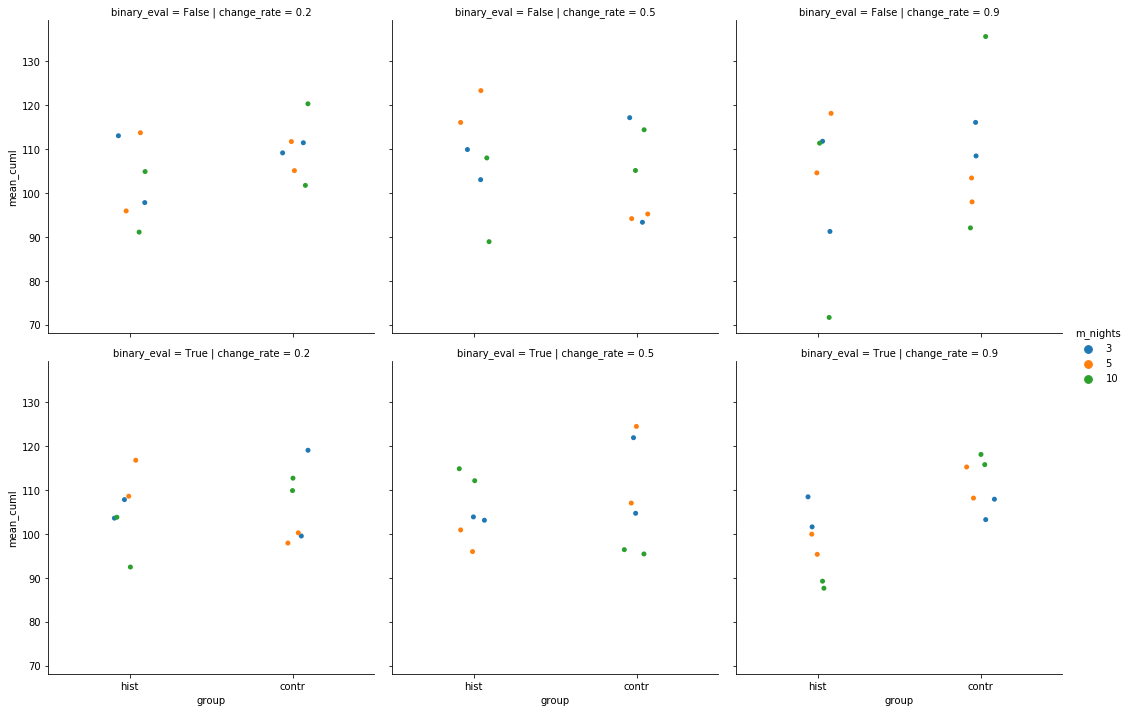

In [75]:
ax = sns.catplot(x="group", y="mean_cuml", hue="m_nights", 
                 row="binary_eval", col="change_rate", data=df_param_contr)

In [76]:
df_param_contr = pd.read_excel("param_stats_high_perf.xlsx", sheet_name="Sheet4")
print(df_param_contr.dtypes)
print(df_param_contr.shape)
df_param_contr.head()

d_threshold      int64
m_nights         int64
change_rate    float64
binary_eval       bool
incl_contra       bool
setting_run      int64
hist_cnt         int64
group           object
mean_cuml      float64
dtype: object
(7200, 9)


,d_threshold,m_nights,change_rate,binary_eval,incl_contra,setting_run,hist_cnt,group,mean_cuml
0,-3,10,0.9,True,True,0,47,hist,4.255319
1,-3,10,0.9,True,True,1,42,hist,83.095238
2,-3,10,0.9,True,True,2,47,hist,343.276596
3,-3,10,0.9,True,True,3,58,hist,224.448276
4,-3,10,0.9,True,True,4,47,hist,47.617021


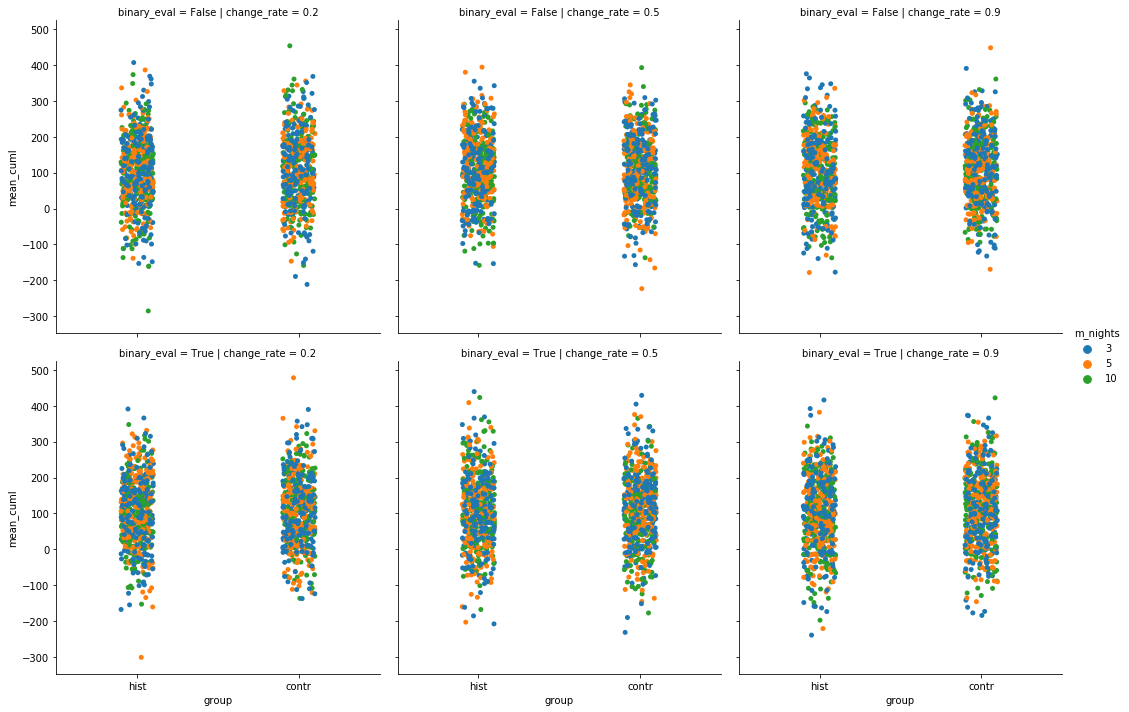

In [79]:
ax = sns.catplot(x="group", y="mean_cuml", hue="m_nights", 
                 row="binary_eval", col="change_rate", data=df_param_contr)

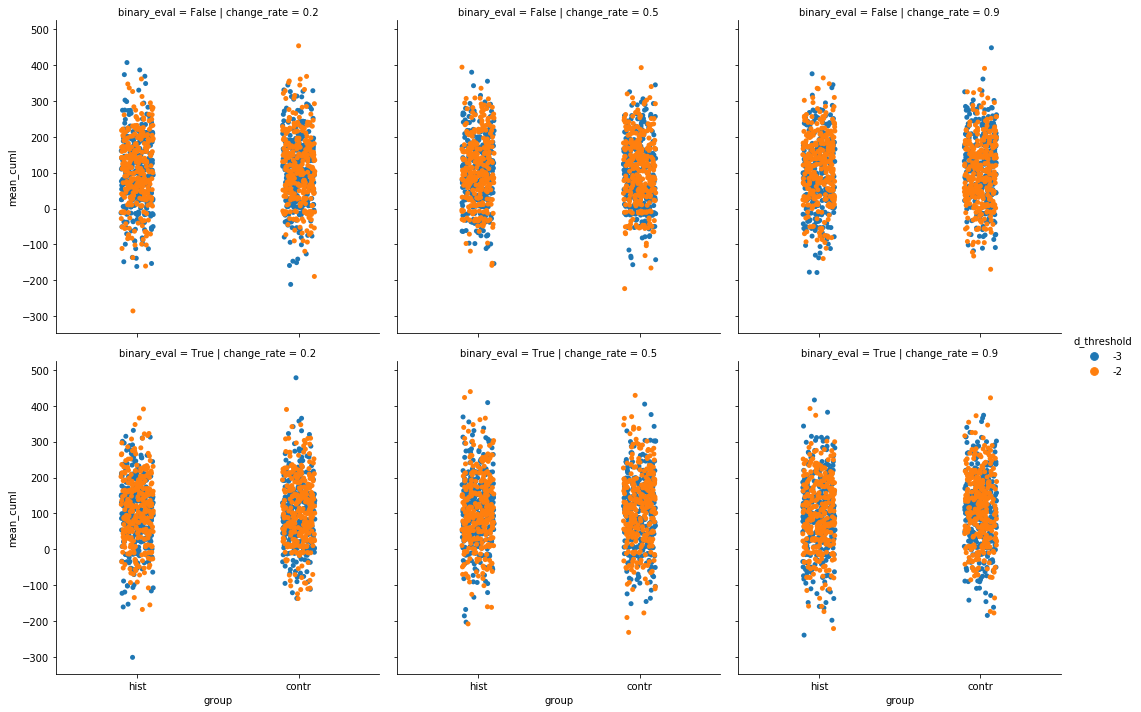

In [78]:
ax = sns.catplot(x="group", y="mean_cuml", hue="d_threshold", 
                 row="binary_eval", col="change_rate", data=df_param_contr)

In [50]:
print(np.sum(df_param_contr.hist_cnt > 50))
df_param_contr[df_param_contr.hist_cnt > 50][df_param_contr.mean_cuml_hist > df_param_contr.mean_cuml_contr].shape[0]

1625


C:\Users\rstancut\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


786

In [49]:
print(np.sum(df_param_contr.hist_cnt < 50))
df_param_contr[df_param_contr.hist_cnt < 50][df_param_contr.mean_cuml_hist < df_param_contr.mean_cuml_contr].shape[0]

1692


C:\Users\rstancut\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


859

In [31]:
df_param_contr.columns

Index(['d_threshold', 'm_nights', 'change_rate', 'binary_eval', 'incl_contra',
       'setting_run', 'mean_cuml', 'hist_cnt', 'mean_cuml_hist', 'contr_cnt',
       'mean_cuml_contr'],
      dtype='object')

In [64]:
df_sub_hist = df_param_contr[['d_threshold', 'm_nights', 'change_rate', 'binary_eval', 'incl_contra',
                   'setting_run', 'hist_cnt', 'mean_cuml_hist']]

df_sub_hist.columns = [['d_threshold', 'm_nights', 'change_rate', 'binary_eval', 'incl_contra',
                   'setting_run', 'hist_cnt', 'mean_cuml']]

df_sub_hist['hist'] = 1
print(df_sub_hist.shape)
df_sub_hist.head()

(3600, 9)


C:\Users\rstancut\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,d_threshold,m_nights,change_rate,binary_eval,incl_contra,setting_run,hist_cnt,mean_cuml,hist
0,-3,10,0.9,True,True,0,47,4.255319,1
1,-3,10,0.9,True,True,1,42,83.095238,1
2,-3,10,0.9,True,True,2,47,343.276596,1
3,-3,10,0.9,True,True,3,58,224.448276,1
4,-3,10,0.9,True,True,4,47,47.617021,1


In [65]:
df_sub_contr = df_param_contr[['d_threshold', 'm_nights', 'change_rate', 'binary_eval', 'incl_contra',
                   'setting_run', 'hist_cnt', 'mean_cuml_contr']]

df_sub_contr.columns = [['d_threshold', 'm_nights', 'change_rate', 'binary_eval', 'incl_contra',
                   'setting_run', 'hist_cnt', 'mean_cuml']]

df_sub_contr['hist'] = 0
print(df_sub_contr.shape)
df_sub_contr.head()

(3600, 9)


C:\Users\rstancut\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,d_threshold,m_nights,change_rate,binary_eval,incl_contra,setting_run,hist_cnt,mean_cuml,hist
0,-3,10,0.9,True,True,0,47,194.075472,0
1,-3,10,0.9,True,True,1,42,120.000000,0
2,-3,10,0.9,True,True,2,47,-108.415094,0
3,-3,10,0.9,True,True,3,58,-62.047619,0
4,-3,10,0.9,True,True,4,47,155.094340,0


In [66]:
frames = [df_sub_hist, df_sub_contr]
df_param_contr_longer = pd.concat(frames, ignore_index=True)

print(df_param_contr_longer.shape)
df_param_contr_longer.head()

(7200, 9)


,d_threshold,m_nights,change_rate,binary_eval,incl_contra,setting_run,hist_cnt,mean_cuml,hist
0,-3,10,0.9,True,True,0,47,4.255319,1
1,-3,10,0.9,True,True,1,42,83.095238,1
2,-3,10,0.9,True,True,2,47,343.276596,1
3,-3,10,0.9,True,True,3,58,224.448276,1
4,-3,10,0.9,True,True,4,47,47.617021,1


In [67]:
df_param_contr_longer.tail()

,d_threshold,m_nights,change_rate,binary_eval,incl_contra,setting_run,hist_cnt,mean_cuml,hist
7195,-2,3,0.2,False,True,95,53,307.574468,0
7196,-2,3,0.2,False,True,96,45,84.218182,0
7197,-2,3,0.2,False,True,97,55,149.822222,0
7198,-2,3,0.2,False,True,98,53,224.042553,0
7199,-2,3,0.2,False,True,99,43,42.140351,0


In [68]:
df_param_contr_longer.dtypes

d_threshold      int64
m_nights         int64
change_rate    float64
binary_eval       bool
incl_contra       bool
setting_run      int64
hist_cnt         int64
mean_cuml      float64
hist             int64
dtype: object

In [71]:
df_param_contr_longer.shape

(7200, 9)

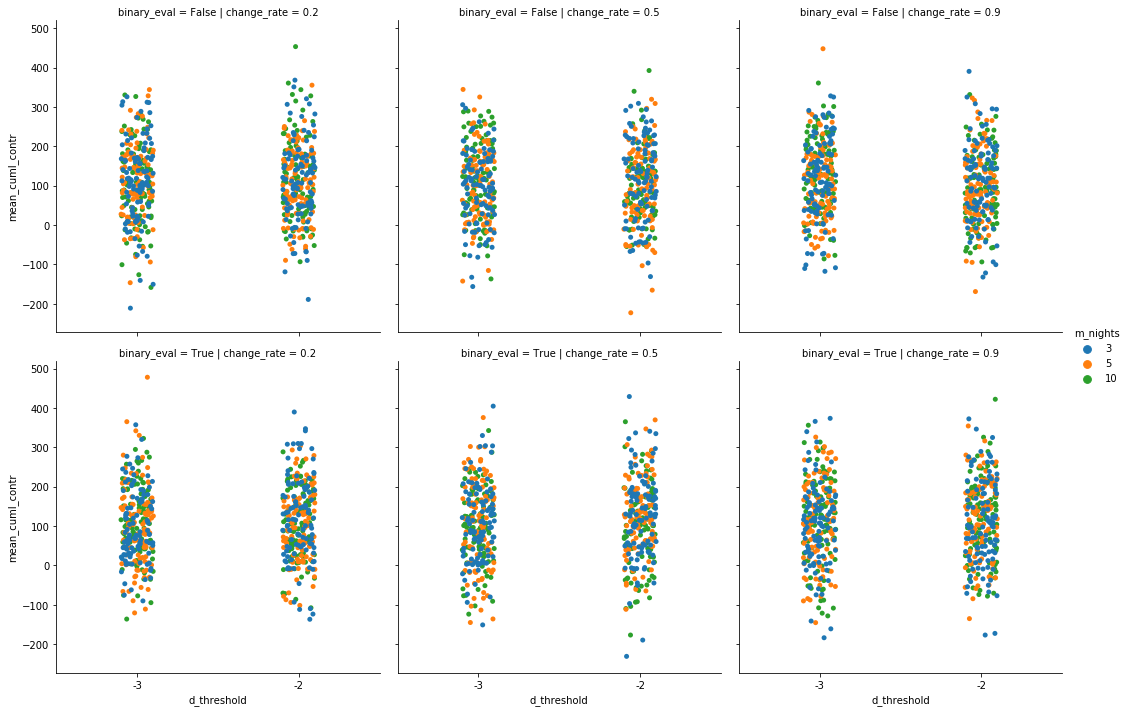

In [59]:
ax = sns.catplot(x="d_threshold", y="mean_cuml_contr", hue="m_nights", row="binary_eval", col="change_rate", 
                 data=df_param_contr)